In [24]:
from ultralytics import YOLO
from roboflow import Roboflow

import torch
import wandb

from matplotlib import pyplot as plt
import seaborn as sns
from PIL import Image
%matplotlib inline

import numpy as np
import pandas as pd
import re, os, dotenv, pathlib
import itertools, tqdm
import json, pickle
dotenv.load_dotenv()

from collections import defaultdict
from scipy.spatial.distance import cdist

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = YOLO('./models/yolov10m-tune-4-v12/weights/best.pt').to(device)

In [3]:
def get_class_coords(detections, box_class, id2label):
    class_coords = defaultdict(list)
    for det, box_cls in zip(detections, box_class):
        x1, y1, x2, y2 = det
        center_x, center_y = (x1 + x2) / 2, (y1 + y2) / 2
        class_coords[id2label[int(box_cls)]].append((center_x, center_y))
    return class_coords

def nearest_neighbor_distances(coords):
    if len(coords) <= 1:
        return [np.inf]
    distances = cdist(coords, coords)
    np.fill_diagonal(distances, np.inf)
    return distances.min(axis=1)

def get_distances(detections, box_class, id2label, px_to_um):
    class_coords = get_class_coords(detections, box_class, id2label)
    all_distances, average_distances = {}, {}
    for class_id, coords in class_coords.items():
        nearest_distances = np.array(nearest_neighbor_distances(coords))
        nearest_distances = nearest_distances[nearest_distances != np.inf]
        distances = nearest_distances * px_to_um
        all_distances[class_id] = distances
        average_distances[class_id] = np.mean(distances)
    return all_distances, average_distances

def get_radius(detections_xywh, box_class, id2label, px_to_um):
    all_radius, average_radius = {}, {}
    radius = detections_xywh[:, 2:].mean(axis=1) / 2 * px_to_um
    for k,v in id2label.items():
        curr_radius = radius[box_class == k]
        all_radius[v] = curr_radius
        average_radius[v] = curr_radius.mean()
    return all_radius, average_radius

def get_square(detections_xywh, box_class, id2label, px_to_um):
    all_square, average_square = {}, {}
    a, b = detections_xywh[:, 2:].T / 2
    square = a * b * px_to_um**2 * np.pi
    for k,v in id2label.items():
        curr_square = square[box_class == k]
        all_square[v] = curr_square
        average_square[v] = curr_square.mean()
    return all_square, average_square

def get_share(box_class, id2label):
    share = {}
    for k,v in id2label.items():
        share[v] = round((box_class == k).sum() / box_class.shape[0] * 100, 4)
    return share

def get_share_count(box_class, id2label):
    share = {}
    for k,v in id2label.items():
        share[v] = (box_class == k).sum()
    return share

In [4]:
# img_train_path = pathlib.Path('basil-12/train/images')
# img_val_path = pathlib.Path('basil-12/valid/images')
# txt_train_path = pathlib.Path('basil-12/train/labels')
# txt_val_path = pathlib.Path('basil-12/valid/labels')

In [5]:
img_path_3 = pathlib.Path('./../Железки/Третья партия железок 2024-04-26/')
img_path_4 = pathlib.Path('./../Железки/Четвертая партия 2024-07-10/')

In [6]:
all_distances_ext = defaultdict(list)
all_radius_ext = defaultdict(list)
all_square_ext = defaultdict(list)
count_share_ext = defaultdict(int)

In [7]:
for img_path in itertools.chain(img_path_3.iterdir(), img_path_4.iterdir()):
    if img_path.suffix in ['.txt', '.db']:
        continue

    img_test = Image.open(img_path)
    txt_path = img_path.parent / f'{img_path.stem}.txt'
    try:
        with open(txt_path, 'r') as f:
            txt_test = ''.join(f.readlines())
    except FileNotFoundError:
        print(f'FileNotFoundError: {txt_path}')
        continue

    crop_val = 0.05
    shape = np.array(img_test.size)

    line_in_um = int(re.search('SM_MICRON_MARKER \d+', txt_test).group(0).split(' ')[-1])
    if line_in_um < 50 or line_in_um > 200:
        continue

    img_test_np = np.array(img_test.crop([*(shape*crop_val), *(shape*(1-crop_val))]))
    img_test_np[img_test_np < 240] = 0
    line_in_px_list = np.array([sum(i) // 255 for i in img_test_np])
    threshold = np.percentile(line_in_px_list, 99.25)
    line_in_px_list_threshold = line_in_px_list[line_in_px_list > threshold]
    line_in_px = line_in_px_list_threshold.min() if line_in_px_list_threshold.shape[0] != 0 else line_in_px_list.max()
    px_to_um = line_in_um / line_in_px
    assert line_in_px < 400, 'TO BIG VALUE, PERHAPS ERROR, CHECK IMAGE!'

    out = model(img_test, verbose=False)[0]

    detections = out.boxes.xyxy.cpu().numpy()
    detections_xywh = out.boxes.xywh.cpu().numpy()
    box_class = out.boxes.cls.cpu().numpy()
    id2label = out.names

    all_distances, average_distances = get_distances(detections, box_class, id2label, px_to_um)
    all_radius, average_radius = get_radius(detections_xywh, box_class, id2label, px_to_um)
    all_square, average_square = get_square(detections_xywh, box_class, id2label, px_to_um)
    count_share = get_share_count(box_class, id2label)

    for k,v in all_distances.items():
        all_distances_ext[k].extend(v)
    for k,v in all_radius.items():
        all_radius_ext[k].extend(v)
    for k,v in all_square.items():
        all_square_ext[k].extend(v)
    for k,v in count_share.items():
        count_share_ext[k] += v

    print(line_in_px, line_in_um, px_to_um, img_path)

140 200 1.4285714285714286 ../Железки/Третья партия железок 2024-04-26/PS-Kpr2verL5-sch13.tif
100 100 1.0 ../Железки/Третья партия железок 2024-04-26/PS-V2-niz-sch10.tif
140 200 1.4285714285714286 ../Железки/Третья партия железок 2024-04-26/Vs-5-2ver-sch5.jpg
162 200 1.2345679012345678 ../Железки/Третья партия железок 2024-04-26/PS-Kpr2ver-L1-sch5.tif
140 200 1.4285714285714286 ../Железки/Третья партия железок 2024-04-26/Vs-5-2verh-sch4.jpg
FileNotFoundError: ../Железки/Третья партия железок 2024-04-26/PS-V2-ver-sch2x100.txt
102 100 0.9803921568627451 ../Железки/Третья партия железок 2024-04-26/PS-V2ver-L5-sch22.tif
100 100 1.0 ../Железки/Третья партия железок 2024-04-26/K2-niz--sc-952x1i28-x100.jpg
FileNotFoundError: ../Железки/Третья партия железок 2024-04-26/PS-V2-niz-sch3.txt
144 200 1.3888888888888888 ../Железки/Третья партия железок 2024-04-26/PS-Kpr2verL3-sch8.tif
192 100 0.5208333333333334 ../Железки/Третья партия железок 2024-04-26/PS-V2-nizx100-960x1i28.tif
140 200 1.42857142

Mean of empty slice.
invalid value encountered in divide
Mean of empty slice.


101 100 0.9900990099009901 ../Железки/Третья партия железок 2024-04-26/PS-V2ver-L5-sch31.tif
140 200 1.4285714285714286 ../Железки/Третья партия железок 2024-04-26/Vs-5-2niz-sch2.jpg
139 200 1.4388489208633093 ../Железки/Третья партия железок 2024-04-26/K2-niz--sc6.jpg
139 200 1.4388489208633093 ../Железки/Третья партия железок 2024-04-26/K2-niz--sc4.jpg
101 100 0.9900990099009901 ../Железки/Третья партия железок 2024-04-26/PS-V2ver-L6-sch35.tif
141 200 1.4184397163120568 ../Железки/Третья партия железок 2024-04-26/PS-Kpr2niz-L3-sch6.tif


Mean of empty slice.
invalid value encountered in scalar divide


253 50 0.1976284584980237 ../Железки/Третья партия железок 2024-04-26/PS-V2niz-L4-s.tif
101 100 0.9900990099009901 ../Железки/Третья партия железок 2024-04-26/PS-V2ver-L4-sch23.tif
140 200 1.4285714285714286 ../Железки/Третья партия железок 2024-04-26/PS-Kpr2niz-L6-sch18.tif
144 200 1.3888888888888888 ../Железки/Третья партия железок 2024-04-26/PS-Kpr2verL5sch12.tif
141 200 1.4184397163120568 ../Железки/Третья партия железок 2024-04-26/PS-V2-niz-L2sch16.tif
140 200 1.4285714285714286 ../Железки/Третья партия железок 2024-04-26/Vs-5-2niz-sch3.jpg
101 100 0.9900990099009901 ../Железки/Третья партия железок 2024-04-26/PS-V2ver-L8-sch39.tif
140 200 1.4285714285714286 ../Железки/Третья партия железок 2024-04-26/PS-Kpr2-ver-L7-sch24.tif
140 200 1.4285714285714286 ../Железки/Третья партия железок 2024-04-26/K2-niz-melk-stol.jpg
101 100 0.9900990099009901 ../Железки/Третья партия железок 2024-04-26/PS-V2ver-L6-sch36.tif
102 100 0.9803921568627451 ../Железки/Третья партия железок 2024-04-26/PS-



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



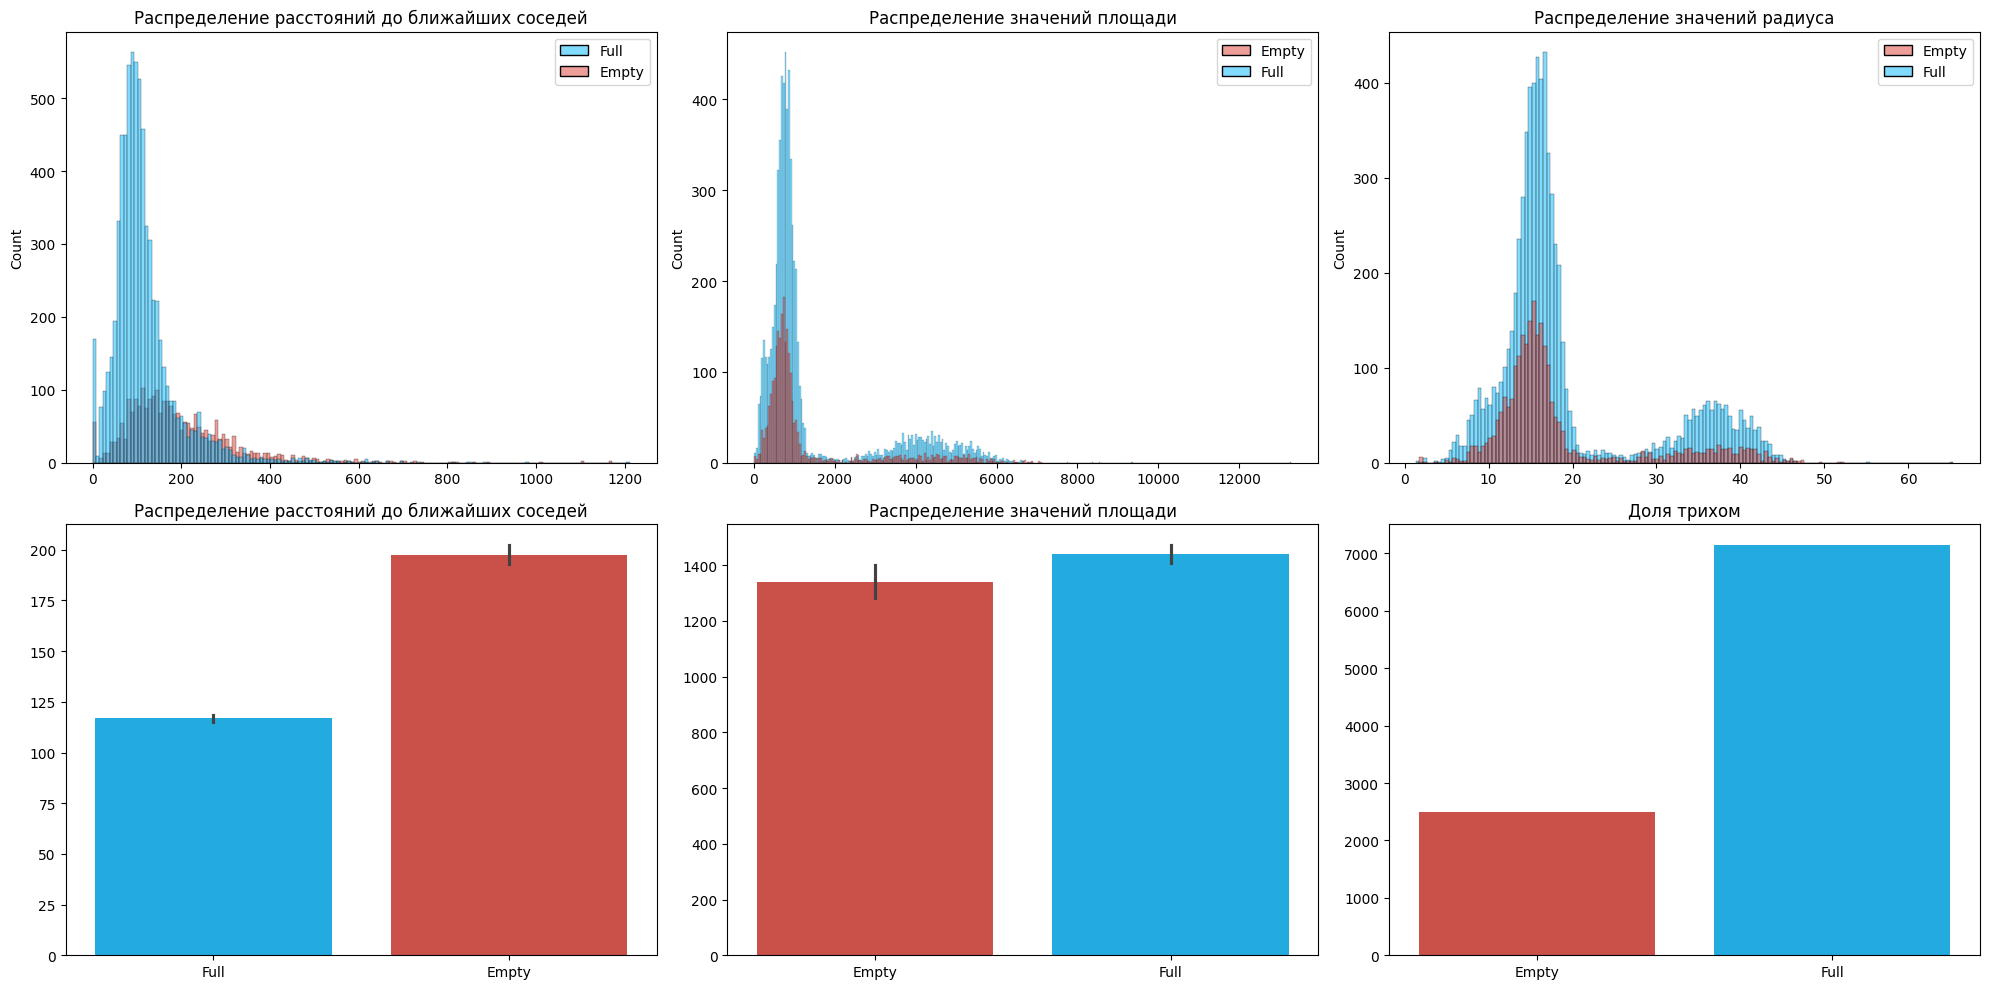

In [8]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(20, 10))
palette={'Full':'#04b9ff', 'Empty':'#de3e35'}

ax[0, 0].set_title('Распределение расстояний до ближайших соседей')
sns.histplot(all_distances_ext, ax=ax[0, 0], palette=palette)

ax[0, 1].set_title('Распределение значений площади')
sns.histplot(all_square_ext, ax=ax[0, 1], palette=palette)

ax[0, 2].set_title('Распределение значений радиуса')
sns.histplot(all_radius_ext, ax=ax[0, 2], palette=palette)

ax[1, 2].set_title('Доля трихом')
sns.barplot(count_share_ext, ax=ax[1, 2], palette=palette)

ax[1, 0].set_title('Распределение расстояний до ближайших соседей')
sns.barplot(all_distances_ext, ax=ax[1, 0], palette=palette)

ax[1, 1].set_title('Распределение значений площади')
sns.barplot(all_square_ext, ax=ax[1, 1], palette=palette)

plt.tight_layout()
plt.show()

In [26]:
data = {
    "all_distances_ext": all_distances_ext,
    "all_radius_ext": all_radius_ext,
    "all_square_ext": all_square_ext,
    "count_share_ext": count_share_ext,
}

with open('./variables.pkl', 'wb') as f:
    pickle.dump(data, f)